In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'experiments/'

### Needed Constants and Variables

In [4]:
SURVEY_ZONE_MAPPING = {'30': (2, 2, 0), '22': (3, 1, 2), '2c': (2, 0, 0), '28': (2, 2, 1), '25': (3, 2, 1), '26': (3, 1, 1), '27': (3, 0, 1), '20': (2, 2, 2), '21': (3, 2, 2), '1e': (3, 1, 2), '23': (3, 0, 2), '24': (2, 0, 1), '29': (3, 2, 1), '1a': (3, 1, 3), '0': (1, 0, 3), '3': (3, 1, 0), '2': (3, 2, 0), '5': (1, 0, 0), '1d': (3, 2, 2), '7': (2, 1, 1), '1f': (3, 0, 2), '9': (3, 1, 1), '8': (3, 2, 1), '3a': (3, 1, 3), '1c': (2, 0, 2), '4': (3, 0, 0), 'a': (3, 0, 1), '6': (1, 0, 1), '39': (3, 2, 3), '12': (1, 0, 2), '3b': (3, 0, 3), '1b': (3, 0, 3), 'b': (1, 0, 2), '13': (1, 0, 2), 'd': (3, 2, 2), '11': (1, 0, 3), '10': (1, 0, 3), 'c': (2, 1, 2), '38': (2, 0, 3), '15': (1, 0, 1), '14': (1, 0, 1), '17': (1, 0, 0), 'f': (3, 0, 2), '19': (3, 2, 3), '32': (3, 1, 0), '31': (3, 2, 0), '16': (1, 0, 0), '37': (3, 0, 3), '36': (3, 1, 3), '35': (3, 2, 3), '34': (2, 1, 3), '2d': (3, 2, 0), '2e': (3, 1, 0), '2f': (3, 0, 0), '1': (2, 1, 0), '2a': (3, 1, 1), '2b': (3, 0, 1), '18': (2, 2, 3), '33': (3, 0, 0), 'e': (3, 1, 2)}

In [51]:
_demands = [
    450,
    900,
    (450, 900),
    (900, 1800)
]

_weights = [
    (0.8, 0.1, 0.1),
    (0.1, 0.8, 0.1),
    (0.1, 0.1, 0.8),
    (0.45, 0.45, 0.1),
    (0.1, 0.45, 0.45),
    (0.45, 0.1, 0.45),
    (0.33, 0.33, 0.33),
    (0, 0, 0),
]

_model_type = {
    (0.8, 0.1, 0.1): 'Delay priority',
    (0.1, 0.8, 0.1): 'Throughput priority',
    (0.1, 0.1, 0.8): 'Flow priority',
    (0.45, 0.45, 0.1): 'Delay-Throughput priority',
    (0.1, 0.45, 0.45): 'Throughput-Flow priority',
    (0.45, 0.1, 0.45): 'Delay-Flow priority',
    (0.33, 0.33, 0.33): 'Equal priority',
    (0, 0, 0): 'Parent model',
}

cols = [
    'Delay priority',
    'Throughput priority',
    'Flow priority',
    'Delay-Throughput priority',
    'Throughput-Flow priority',
    'Delay-Flow priority',
    'Equal priority',
    'Parent model'
]

In [5]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 0.25,
    'r_through': 0.5,
    'r_right': 0.25,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20,
    'flow_rate_reduction': 1
}


## Loading dataframes

In [58]:
# Results of the MILP solver only (Expected)

df_milp = pd.read_pickle(DF_PATH + 'milp-realtime-results.pkl')

df_milp.head()

,runtime,delay,throughput,objective_value,demand,new_model,alpha,beta,gamma,model_type,epoch
0,174.118326,1534.544304,51.278481,382.056221,450,True,0.80,0.10,0.10,Delay priority,0
5,456.304917,1534.544304,51.278481,-598.035046,450,True,0.45,0.10,0.45,Delay-Flow priority,0
3,343.920306,1534.544304,51.278481,49.987495,450,True,0.45,0.45,0.10,Delay-Throughput priority,0
6,917.078324,1534.544304,51.278481,-487.789937,450,True,0.33,0.33,0.33,Equal priority,0
2,891.892373,1602.215190,54.000000,-1585.763682,450,True,0.10,0.10,0.80,Flow priority,0


In [59]:
# Results of the LocalSim simulator only (Actual)

df_ave_delay = pd.read_pickle(DF_PATH + 'ave_delay.pkl')
df_total_delay = pd.read_pickle(DF_PATH + 'total_delay.pkl')
df_total_thru = pd.read_pickle(DF_PATH + 'total_throughput.pkl')

df_total_thru.head()

level_1,"(1, 0, 0)","(1, 0, 1)","(1, 0, 2)","(1, 0, 3)",demand,new_model,alpha,beta,gamma,model_type
0,1089.0,1016.0,999.0,986.0,450,True,0.80,0.10,0.10,Delay priority
1,1016.0,973.0,960.0,969.0,450,True,0.10,0.10,0.80,Flow priority
2,994.0,1046.0,766.0,1072.0,450,True,0.10,0.80,0.10,Throughput priority
3,885.0,899.0,770.0,929.0,450,False,0.00,0.00,0.00,Parent model
4,984.0,936.0,1006.0,911.0,450,True,0.33,0.33,0.33,Equal priority


In [60]:
# Comparing computed and measured values (Expected vs Actual)

df_delay_comp = pd.read_pickle(DF_PATH + 'delay_comparison.pkl')
df_thru_comp = pd.read_pickle(DF_PATH + 'throughput_comparison.pkl')

df_delay_comp.head()

,demand,model_type,expected,actual,epoch
95,450,Delay priority,1534.544304,791.155594,0
94,450,Delay priority,8911.316456,10869.134698,1
93,450,Delay priority,14393.012658,23863.123553,2
92,450,Throughput priority,1583.215190,586.911273,0
91,450,Throughput priority,8653.316456,8391.820189,1


## Checking actual delay in the 32 cases

In [53]:
df_total_delay['total_delay_sansleft'] = df_total_delay.iloc[:, 4:24].sum(axis=1)
df_total_delay_table = df_total_delay.pivot(index='demand', columns='model_type', values='total_delay_sansleft')[cols]

df_total_delay_table = df_total_delay_table.apply(lambda x: x / 3600)

print("Total actual delay over 10 minutes (in vehicle-hours)")
df_total_delay_table

Total actual delay over 10 minutes (in vehicle-hours)


model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,42.553468,33.556231,41.356801,35.403162,34.379403,49.176240,45.480330,7.454364
900,93.105136,91.408407,91.538607,90.417405,94.294898,86.018836,89.032999,40.620088
"(450, 900)",55.418965,67.552681,66.702238,60.552466,71.827282,59.741712,76.147962,34.454994
"(900, 1800)",93.072660,92.690149,94.799806,90.795830,93.894937,92.345845,96.824786,53.273647


## Checking actual throughput in the 32 cases

In [54]:
df_total_thru['total_throughput'] = df_total_thru.iloc[:, :4].sum(axis=1)
df_total_thru_table = df_total_thru.pivot(index='demand', columns='model_type', values='total_throughput')[cols]

print("Total actual throughput over 10 minutes (in vehicles)")
df_total_thru_table

Total actual throughput over 10 minutes (in vehicles)


model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,4090.0,3878.0,3918.0,3798.0,3980.0,3857.0,3837.0,3483.0
900,4978.0,5050.0,5123.0,4925.0,5058.0,5077.0,5040.0,6151.0
"(450, 900)",4739.0,4428.0,4464.0,4436.0,4476.0,4621.0,4444.0,4559.0
"(900, 1800)",5326.0,5369.0,5270.0,5242.0,5232.0,5148.0,5321.0,6189.0


## Checking initial computation runtime in the 32 cases

In [71]:
df_milp[df_milp.epoch == 0].pivot(index='demand', columns='model_type', values='runtime')[cols]

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,174.118326,415.136684,891.892373,343.920306,596.610098,456.304917,917.078324,0.227479
900,5.594564,79.814373,107.079304,12.111818,113.854813,6.865374,11.656718,0.196067
"(450, 900)",45.695386,184.570850,270.988164,54.453104,228.198814,65.908537,78.775772,0.237932
"(900, 1800)",2.259045,3.190047,5.966135,4.089121,4.800086,2.255693,1.928007,0.156675


## Checking recomputation runtime in the 32 cases (average across epochs)

In [70]:
df_milp[df_milp.epoch != 0].pivot_table(index='demand', columns='model_type', values='runtime', aggfunc='mean')[cols]

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,2.961140,2.873061,3.237333,2.843178,2.735562,2.651713,2.915706,0.124217
900,2.158557,1.985901,1.500374,2.340586,1.965661,2.158847,2.018723,0.152828
"(450, 900)",2.658140,2.902532,2.397003,3.090973,2.792279,2.448191,2.594204,0.131111
"(900, 1800)",2.078627,2.189268,2.197879,1.840762,2.082379,1.976440,2.057974,0.111880


## Checking error of computed and measured delay

In [63]:
df_delay_comp['error'] = df_delay_comp.apply(lambda row: (row.expected - row.actual) * 100 / (row.expected), axis=1)
df_delay_error = df_delay_comp.pivot_table(index='demand', columns='model_type', values='error', aggfunc=np.mean)[cols]

print("Percent error of delay")
print("Note: values for parent model may be inaccurate, due to no left turns being measured")
df_delay_error

Percent error of delay
Note: values for parent model may be inaccurate, due to no left turns being measured


model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,-13.107665,5.317447,-7.675738,-3.723378,5.496220,-18.416084,-12.729012,68.272278
900,-28.016781,-24.902654,-25.287854,-25.448965,-33.224303,-20.157838,-19.815322,38.423091
"(450, 900)",-15.284490,-15.986663,-15.726458,-17.148809,-17.930562,-19.175261,-31.014811,31.024736
"(900, 1800)",-9.478884,-9.982162,-13.251683,-10.215370,-9.759846,-8.571945,-15.956231,35.002148


## Checking error of computed and measured throughput

In [66]:
df_thru_comp['error'] = df_thru_comp.apply(lambda row: (row.expected - row.actual) * 100 / (row.expected), axis=1)
df_thru_error = df_thru_comp.pivot_table(index='demand', columns='model_type', values='error', aggfunc=np.mean)[cols]

print("Percent error of throughput")
df_thru_error

Percent error of throughput


model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,-404.582487,-354.957073,-368.001141,-360.326559,-376.982624,-373.484280,-356.426469,-283.532573
900,-482.898673,-495.213800,-524.643793,-477.536586,-502.379251,-493.658991,-495.560387,-542.351912
"(450, 900)",-462.821881,-429.972305,-416.514276,-429.131400,-426.789328,-453.080442,-435.351436,-382.994063
"(900, 1800)",-540.120152,-562.929763,-527.482186,-532.570815,-515.008091,-513.269586,-532.939911,-565.050955


## Plot of cumulative delay (lower curve is better)

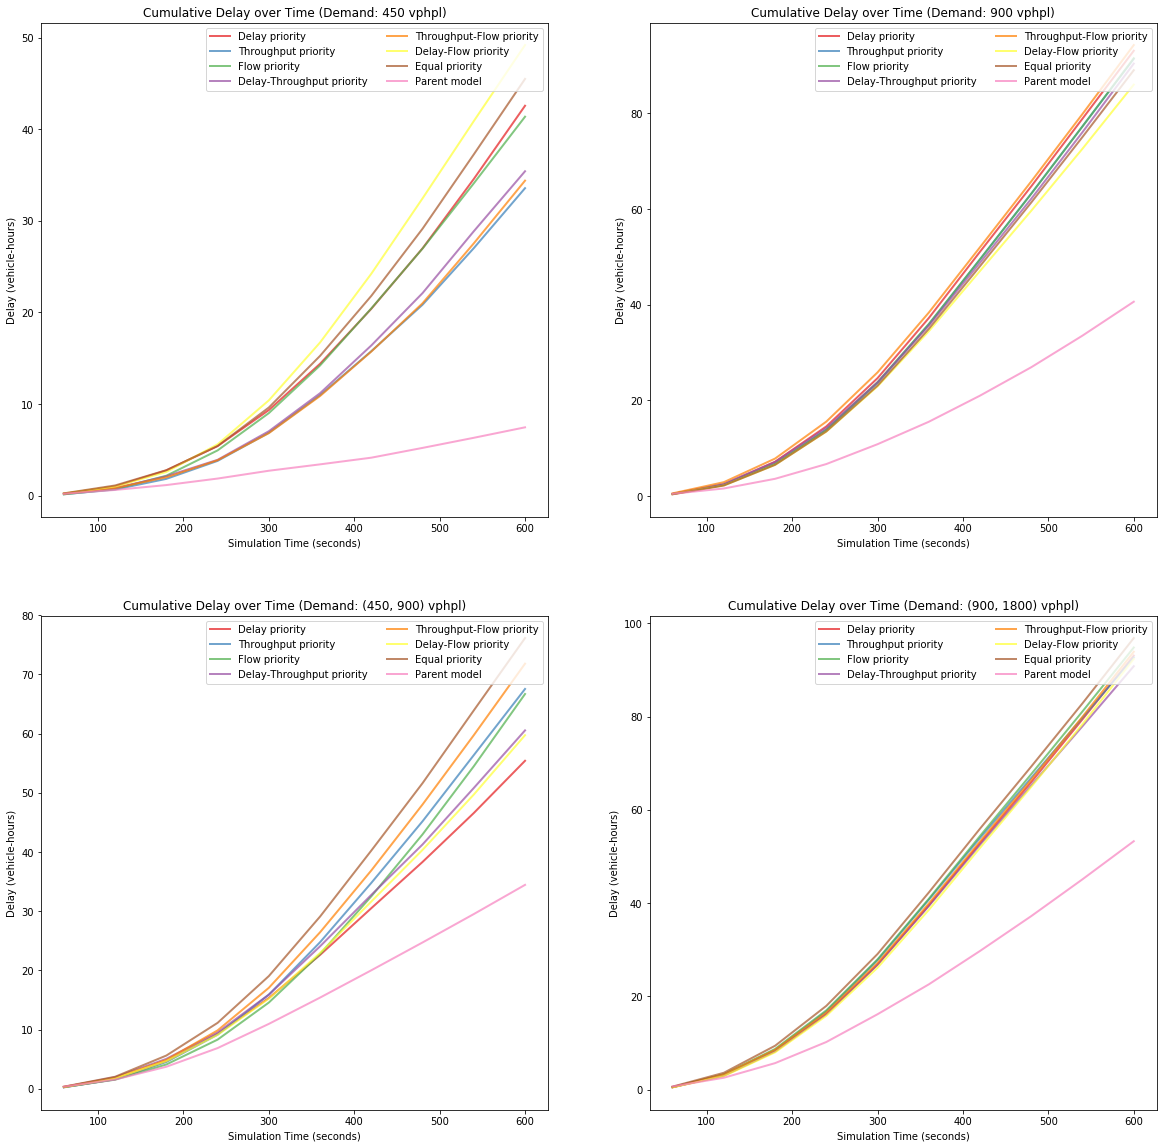

In [99]:
fig, axs = plt.subplots(2,2,figsize=(20,20))

for ndx, demand in enumerate(_demands):

    df_cumudelays = pd.DataFrame(index=[x for x in range(60,601,60)])

    for weights in _weights:
        df_tmp = pd.read_pickle(DF_PATH + 'cumu-delay/delay_d{}_a{}_b{}_c{}.pkl'.format(demand, *weights))
        df_cumudelays[_model_type[weights]] = df_tmp.iloc[:, 4:].sum(axis=1).apply(lambda x: x / 3600)
        
    palette = plt.get_cmap('Set1')
    num=0

    for column in df_cumudelays:
        axs[ndx / 2, ndx % 2].plot(df_cumudelays.index, df_cumudelays[column], marker='', color=palette(num), linewidth=2, alpha=0.7, label=column)
        num+=1

    # Add legend
    axs[ndx / 2, ndx % 2].legend(loc=1, ncol=2)

    # Add titles
    axs[ndx / 2, ndx % 2].set_title("Cumulative Delay over Time (Demand: {} vphpl)".format(demand))
    axs[ndx / 2, ndx % 2].set_xlabel("Simulation Time (seconds)")
    axs[ndx / 2, ndx % 2].set_ylabel("Delay (vehicle-hours)")

## Plot of cumulative throughput (higher is better)

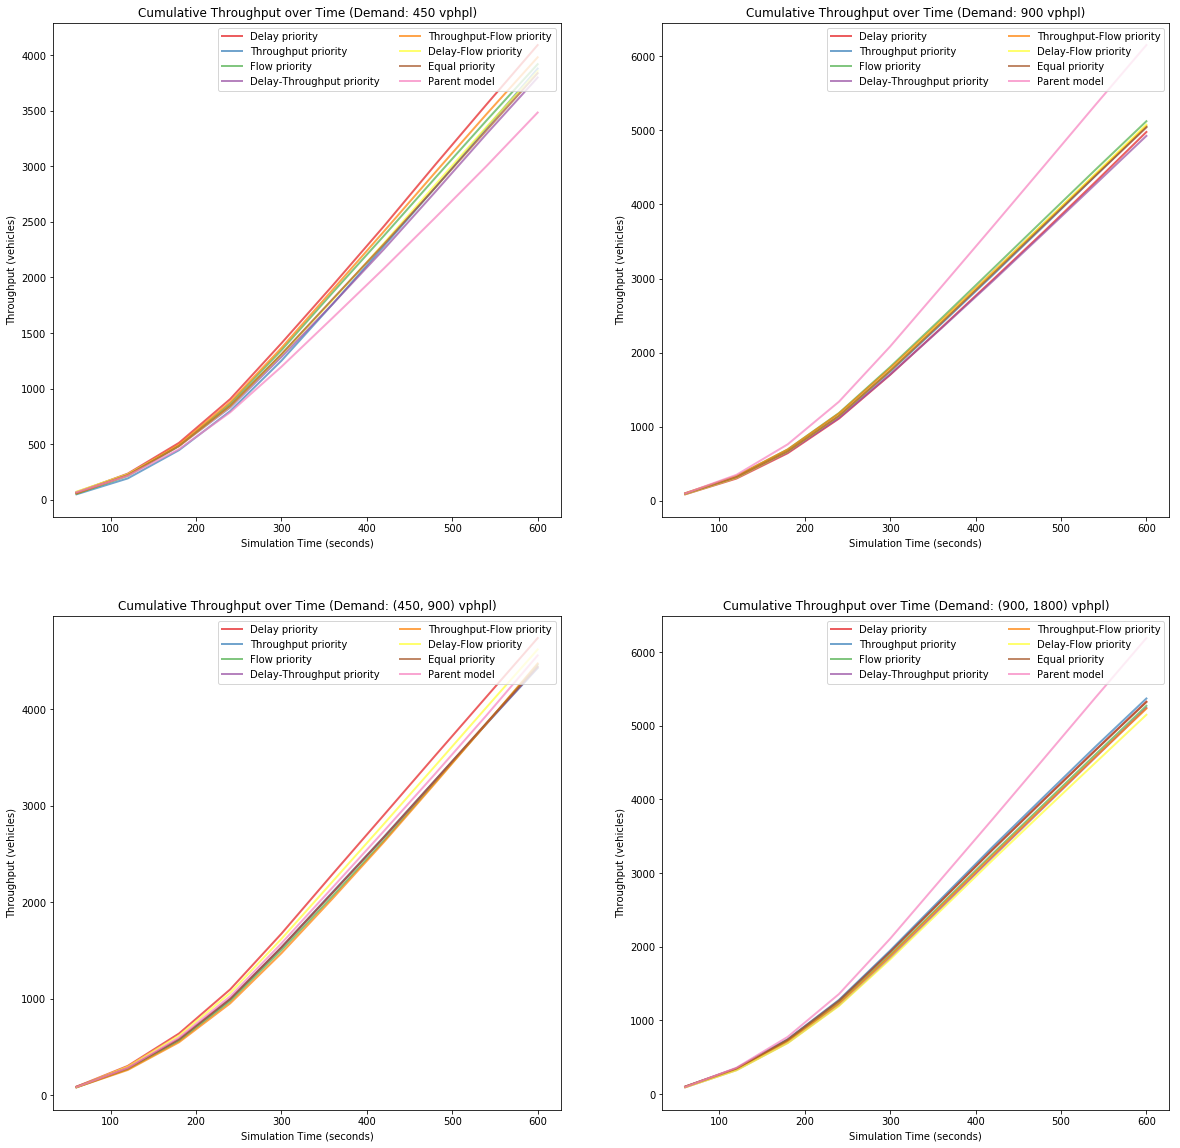

In [106]:
fig, axs = plt.subplots(2,2,figsize=(20,20))

for ndx, demand in enumerate(_demands):

    df_cumuthrus = pd.DataFrame(index=[x for x in range(60,601,60)])

    for weights in _weights:
        df_tmp = pd.read_pickle(DF_PATH + 'cumu-thru/thru_d{}_a{}_b{}_c{}.pkl'.format(demand, *weights))
        df_cumuthrus[_model_type[weights]] = df_tmp.sum(axis=1)
        
    palette = plt.get_cmap('Set1')
    num=0

    for column in df_cumuthrus:
        axs[ndx / 2, ndx % 2].plot(df_cumuthrus.index, df_cumuthrus[column], marker='', color=palette(num), linewidth=2, alpha=0.7, label=column)
        num+=1

    # Add legend
    axs[ndx / 2, ndx % 2].legend(loc=1, ncol=2)

    # Add titles
    axs[ndx / 2, ndx % 2].set_title("Cumulative Throughput over Time (Demand: {} vphpl)".format(demand))
    axs[ndx / 2, ndx % 2].set_xlabel("Simulation Time (seconds)")
    axs[ndx / 2, ndx % 2].set_ylabel("Throughput (vehicles)")